In [1]:
!pip install editdistance
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q
!pip install editdistance

import locale
import pandas as pd
import numpy as np
import re
import sys
import typing as tp
import unicodedata
import gc
import random
import torch
import sacrebleu
import editdistance
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig, get_constant_schedule_with_warmup
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from sacremoses import MosesPunctNormalizer

pd.options.display.max_colwidth = 100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 44.9 MB/s eta 0:00:00


In [2]:
trans_df = pd.read_csv('trans_df.csv')

trans_df.drop(columns = 'Unnamed: 0', inplace = True)
trans_df = trans_df[trans_df.ru.notna()]
print(trans_df.isnull().sum())

print(trans_df.split.value_counts())

df_train = trans_df[trans_df.split=='train'].copy()
df_dev = trans_df[trans_df.split=='dev'].copy()
df_test = trans_df[trans_df.split=='test'].copy()

ru       0
tyv      0
split    0
dtype: int64
split
train    108183
test       5000
dev        4999
Name: count, dtype: int64


In [3]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-1.3B')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/808 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [4]:
sum(p.numel() for p in model.parameters())

1370638336

In [5]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

In [6]:
def word_tokenize(text):
    return re.findall('(\w+|[^\w\s])', text)

texts_with_unk = [text for text in tqdm(trans_df.tyv) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/118182 [00:00<?, ?it/s]

3646


In [7]:
mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [8]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/3646 [00:00<?, ?it/s]

18


In [9]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [10]:
fix_tokenizer(tokenizer)

In [11]:
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]

[256202, 256203, 256204]


In [12]:
added_token_id = tokenizer.convert_tokens_to_ids('tyv_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [13]:
model.resize_token_embeddings(len(tokenizer))

# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [14]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [15]:
model.cuda();

In [16]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [17]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [18]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [19]:
LANGS = [('ru', 'rus_Cyrl'), ('tyv', 'tyv_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['чеди'], ['семь'], 'tyv_Cyrl', 'rus_Cyrl')

(['четыреста семнадцать'], ['дөрт чүс он чеди'], 'rus_Cyrl', 'tyv_Cyrl')


In [20]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

  0%|          | 0/57000 [00:00<?, ?it/s]

0 6.1981401443481445
1000 3.1529358872175215
2000 2.138706855118275
3000 1.7899368283152581
4000 1.6332649536728858
5000 1.524365034222603
6000 1.4267976861596108
7000 1.3465234941840172
8000 1.2710091817080975
9000 1.2280698446035385
10000 1.1869425070285797
11000 1.1285312429964542
12000 1.1062982225120068
13000 1.066570529639721
14000 1.0485289284884929
15000 0.9982879633009434
16000 0.9592826029062271
17000 0.94145412799716
18000 0.9285180440247058
19000 0.885615561336279
20000 0.8677851341664791
21000 0.8538520890176297
22000 0.8280291534811258
23000 0.8203731724917889
24000 0.7884847463667393
25000 0.7731225547790528
26000 0.7472872257828712
27000 0.7342814952135086
28000 0.7087002568542957
29000 0.6857564555108547
30000 0.6722343716919422
31000 0.6664008520692587
32000 0.6422705011665821
33000 0.6303395496457815
34000 0.6161339382827282
35000 0.5975178730934858
36000 0.6022958312779665
37000 0.5787941613197327
38000 0.5450034978687763
39000 0.5465836440175772
40000 0.54654094045

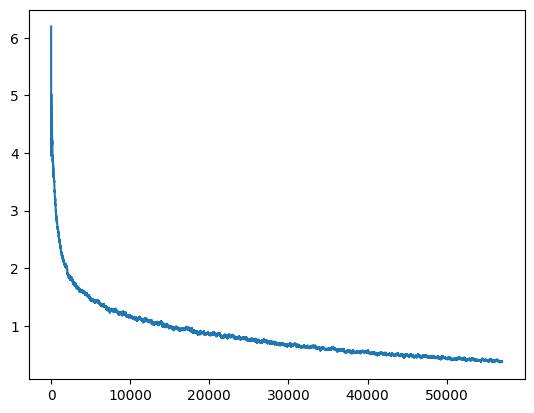

In [21]:
pd.Series(losses).ewm(100).mean().plot();

In [22]:
def translate(text, src_lang='rus_Cyrl', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [23]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/4999 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [24]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [25]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 24.74 51.7/30.1/19.4/13.0 (BP = 0.988 ratio = 0.988 hyp_len = 22937 ref_len = 23207)
chrF2++ = 48.57
BLEU = 22.92 51.4/28.9/17.7/11.1 (BP = 0.986 ratio = 0.986 hyp_len = 22857 ref_len = 23188)
chrF2++ = 50.78


In [26]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [27]:
upload_repo = "Nacoor/tyvan_1.3"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.48G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nacoor/tyvan_1.3/commit/4baa881d67783785627a42f9d36c1e204e3bc4f1', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='4baa881d67783785627a42f9d36c1e204e3bc4f1', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
MODEL_URL = 'Nacoor/tyvan_1.3'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

In [28]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [30]:
translate("когда моя мама приехала домой, мои друзья уже начали есть", model=model, tokenizer=tokenizer)

'кажан авам бажыңга чедип келгенде, эштерим чемненип эгелээн'